In [1]:
import matplotlib
import argparse
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn # import modules

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models_v1.Update import LocalUpdate
from models_v1.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, MobileNetV2, LeNet5, LeNet10
from models_v1.Fed import FedAvg
from models_v1.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models_v1.test import test_img

%load_ext autoreload
%autoreload 2
from torch.autograd import grad
parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
parser.add_argument('--index', type=int, default="25",
                    help='the index for leaking images on CIFAR.')
parser.add_argument('--image', type=str,default="",
                    help='the path to customized image.')
args = parser.parse_args([])
from torch.autograd import grad

/usr/lib/python3/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/lib/python3/dist-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
class my_argument:    
    epochs = 400    #"rounds of training"
    num_users = 100  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=10 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.001 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'SGD'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=0
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    model='mlp'
    q=20
    f_size=32
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cpu")
args.device = torch.device("cuda:1" if use_cuda else "cpu")
print(args.device)

True
cuda:1


In [3]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient, weight_vectorization_gen2


In [4]:
def phiQ(p,sc, q, w):
    w_cap = w #[:,0]
    #w_cap=[item[0] if isinstance(item,list) and len(item)>0 else item for item in w_cap]
    #w_cap=np.array(w_cap)
    #print("w_cap_first")
    #print(w_cap)
    w_cap= sc*w_cap
    v=np.floor(q*w_cap)
    one=np.ones(len(w))
    r=np.random.uniform(0,1,len(w_cap))
    temp=(one.T+np.sign(q*w_cap-v-r))*np.sign(q*w_cap-v-r)
    #j=np.sign(w_cap-v-r)
    #print("jjj")
    #print(j)
    #temp= (1/q)*(1/2)*temp
    temp=(1/2)*temp
    #print("temp")
    #print(temp)
    #w_cap= (1/q)*v + temp
    w_cap=(1/q)*(v+temp)
    w_cap=q*w_cap
    #w_cap=w_cap+ (1/2)*p*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    w_cap=w_cap+ (1/2)*(p-5)*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    #print("w_cap_last")
    #print(w_cap)
    del temp
    del one
    del v
    del r
    return w_cap

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('/data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('/data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
        print('iid dataset')
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
        print("non iid dataset")
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape


non iid dataset


/usr/lib/python3/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [5]:
def toNumpyFlatArray(self):
        return self.flat


def updateFromNumpyFlatArray(self, arr):
    self.flat = arr
    start = 0
    new_glob = OrderedDict()
    for k in self.w_glob.keys():
        size = 1
        for dim in self.w_glob[k].shape:
            size *= dim
        shaped = np.reshape(arr[start : start + size].copy(), self.w_glob[k].shape)
        new_glob[k] = torch.from_numpy(shaped)
        start = start + size
    self.w_glob = new_glob
    self.net_glob.load_state_dict(self.w_glob)

In [6]:
# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        print("iid dataset")
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

In [7]:
beta=[1,1/2,1/4,1/8,1/16]
beta=[1,1,1/2,1/2,1/4]
comp=[]
i=0
for j in range(args.num_users):
    comp.append(beta[i])
    if (j>0 and j%20==0):
        i+=1


In [8]:
print(comp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [ ]:
#print(dict_users[2])

In [ ]:
#print(dict_users[10])

In [ ]:
print(len(dict_users[2]))

# 1. FedAvg with A=0

In [8]:

local_lr = 1e-4
local_steps = 1
use_updates = True

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, torch.nn.Linear):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.BatchNorm2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        #conv1.bias.data.fill_(0.01)

In [17]:
from models_v4.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient
import numpy as np
import copy
import random
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == "mobilenetv2":
    net_glob = MobileNetV2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    print(len_in)
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.apply(weights_init)
net_glob.train()

784
MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=10, bias=True)
)


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=10, bias=True)
)

In [18]:
def update_local_model( w_hold,w_local, sub):
    count=0
    for i in sub:
            w_glob_hold['layer_input.weight'][int(50*i):int(50*(i+1)),:]=w_local['layer_input.weight'][count*50:(count+1)*50,:]
            
            #combined=torch.concatenate((first,middle),axis=0)
    
            w_glob_hold['layer_input.bias'][int(50*i):int(50*(i+1))]=w_local['layer_input.bias'][count*50:(count+1)*50]
            
    
    
            w_glob_hold['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]=w_local['layer_hidden.weight'][:,count*50:(count+1)*50]
            
    
            w_glob_hold['layer_hidden.bias']=w_local['layer_hidden.bias']
            count+=1
            #combined=middle
    #w_glob['layer_hidden.weight']=combined
    return w_glob_hold

In [19]:
print(s_1)

NameError: name 's_1' is not defined

In [20]:
from models_v1.Fed import FedAdd,FedSubstract,weight_vectorization_cifar,FedAvg_gradient, weight_vectorization_gen, weight_vectorization_gen2
#net_glob = LeNet10().to(args.device)
#net_glob.train()
args.lr=0.0005
import torchvision.models as models
dev=torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
net_glob.apply(weights_init)
net_glob.train()
#net_glob.load_state_dict(w_glob)
net_glob=net_glob.to(dev)
net_glob.train()
# copy weights
#net_glob=torch.hub.load('pytorch/vision:v0.10.0','resnet18',pretrained=False)
#net_glob.eval()
w_glob = net_glob.state_dict()
g, dim = weight_vectorization_gen(w_glob)

w_glob=net_glob.state_dict()
# print(w_glob)
# print(w_glob.keys())
for k in w_glob.keys():
    print(w_glob[k].shape)
net_glob_original=copy.deepcopy(net_glob)
net_glob_original.to(dev)
w_glob_original=copy.deepcopy(w_glob)
w_glob_hold=net_glob_original.state_dict()
#print(w_glob_hold)
for h in w_glob_hold.keys():
    print(w_glob_hold[h].shape)
    #print(w_glob[h])
    w_glob_hold[h]=torch.zeros(w_glob_hold[h].shape)
    print(type(w_glob[h]))

torch.Size([200, 784])
torch.Size([200])
torch.Size([10, 200])
torch.Size([10])
torch.Size([200, 784])
<class 'torch.Tensor'>
torch.Size([200])
<class 'torch.Tensor'>
torch.Size([10, 200])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>


In [21]:
print(w_glob_original)

OrderedDict([('layer_input.weight', tensor([[-0.0676,  0.0695, -0.0436,  ..., -0.0028,  0.0224,  0.0181],
        [ 0.0330,  0.0357, -0.0237,  ..., -0.0489, -0.0256,  0.0573],
        [-0.0190,  0.0128,  0.0164,  ..., -0.0555,  0.0692,  0.0637],
        ...,
        [-0.0347, -0.0430,  0.0761,  ..., -0.0091, -0.0320,  0.0560],
        [-0.0401, -0.0012, -0.0142,  ..., -0.0336,  0.0392, -0.0406],
        [-0.0755, -0.0028, -0.0557,  ..., -0.0500,  0.0686, -0.0628]],
       device='cuda:1')), ('layer_input.bias', tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [22]:

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

m_local=[]
d=11699132 #resnet18
d= 11173962
d=11183582
d=21840
#d= 11699132
#d=62006
iter_no=2000
avg=[]
error=[]
idxs_users=range(0,args.num_users)
    #print(len(idxs_users))
user_no=args.num_users
updated=[]
a=[]
for user in idxs_users:
        #print(user)
    updated.append([])  
    a.append([])   
model_diff=[]




#net_glob.zero_grad()
input_gradient=[]

user_no=args.num_users

select=round(0.9*user_no)

K_local=round(1*d)
loss_train=[]    
#net_glob.zero_grad()   
for iter in range(iter_no): #args.epochs
    print("iteration no.",iter)
    if (iter>=500):
        args.lr=args.lr/5
    m_local=[]
    f=[]
        #T=[]
    w_locals, loss_locals,diff_locals,grad_locals = [], [],[],[]
    m = 10
    updated=[]
    model_diff=[]
    grad_vect=[]
    prev=[]
    error=[]
    grad_vect_quant=[]
    grad_vect_quant2=[]
    grad_vect_send=[]
    grad_vect_send2=[]
    store_grad=[]
    location_local=[]
    rand=np.random.choice(idxs_users,user_no,replace=False)
    rand=idxs_users
    np.random.seed(iter)
    rand=np.random.choice(idxs_users, select, replace=False)
    rand=np.sort(rand)
    loss_train_user=[]
    for i in range(args.num_users):
        updated.append([])
        model_diff.append([])
        grad_vect.append([])
        prev.append([])
        grad_vect_send.append([])
        error.append(np.zeros(d))
        grad_vect_quant.append([])
    
    
    for user in rand : #rand: #idxs_users:
        #print(user)
        
        w_glob = net_glob_original.state_dict()
        my_list=[0,1,2,3]
        block=int(comp[user]*4)
        sub=[]
        for i in range(block):
            sub.append(random.choice(my_list))
            my_list.remove(sub[i])
       
        #s=s_1[user]
        sub=sorted(sub)
#print(w_glob['layer_input.weight'][:,s:s+10])
        

        y=int(comp[user]*200)
        
        count=0
        for i in sub:
            first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
            #print(first.shape)
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.weight'][int(50*i):int(50*(i+1)),:]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
            #print(combined.shape)
    
        w_glob['layer_input.weight']=combined
        count=0
        for i in sub:
            first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_input.bias'][int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=0)
            count+=1
    
        w_glob['layer_input.bias']=combined
        
        count=0
        for i in sub:
            first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
            if (count==0):
                combined=first
            else:
                first=w_glob['layer_hidden.weight'][:,int(50*i):int(50*(i+1))]
                combined=torch.concatenate((combined,first),axis=1)
            count+=1
        w_glob['layer_hidden.weight']=combined
        
        
        #print(w_glob)
        
        net_glob = MLP(dim_in=len_in, dim_hidden=y, dim_out=args.num_classes).to(args.device)
        net_glob.train()
        net_glob.to(dev)
        
        net_glob.load_state_dict(w_glob)
        #s_1[user]=(s_1[user]+1)%200
        
        prev[user]=copy.deepcopy(w_glob)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[user])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         input_gradient=inversefed.reconstruction_algorithms.loss_steps(net_glob, ground_truth[user], labels[user], 
#                                                         lr=local_lr, local_steps=local_steps,
#                                                                    use_updates=use_updates)
        
        loss_train_user.append(loss)
    
        model_diff=FedSubstract(w,prev[user])
        #print(model_diff)
        
        g, dim = weight_vectorization_gen(model_diff)
        print(len(g))
        
        model_diff=update_local_model(w_glob_hold, model_diff, sub)
        #print(model_diff2)
        
        g, dim = weight_vectorization_gen(model_diff)
        #print(len(g))
        g=g[:,0] #+error[user]
        grad1=abs(np.array(g))
        #location_local=np.random.choice(range(d),K_local,replace=False)
        #location_local=np.argpartition(grad1,-K_local)[-K_local:]
        #a[user].append(np.sort(location_local))
        #if iter>0:
            #print(len(set(a[user][iter-1]).intersection(set(a[user][iter]))))
        #print(a)
#         mask=np.zeros(d)
#         np.put(mask,location_local,1)
        grad_vect[user]= g #np.multiply(g,mask)
        scale=1/(1*0.9*args.num_users)
        grad_vect_quant[user]= phiQ(np.power(2,args.f_size),scale,2**args.q,grad_vect[user])
        #error[user]=g-grad_vect[user]
        grad_locals.append(grad_vect_quant[user])
        del g
        print(user)
    grad_avg=sum(grad_locals) #/len(grad_locals)
    loss_train.append(sum(loss_train_user)/len(loss_train_user))
    grad_avg=sum(grad_locals) # taking the average of masked gradients
    #grad_avg2=np.nan_to_num(sum(grad_locals2))
    #print("grad_avg")
    #print(grad_avg)
    grad_avg_correct = np.zeros_like(grad_avg)
    #print("before modulo")
    #print(grad_avg)
    grad_avg= (grad_avg)%(np.power(2,args.f_size)-5)
    #print("after modulo")
    #print(grad_avg)
    p=np.power(2,args.f_size)-5
    for i in range(len(grad_avg)):
        if grad_avg[i]>=0 and grad_avg[i]<(p-1)/2:
                        # print("Valid")
            grad_avg_correct[i]=grad_avg[i]
            grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
            #grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
            continue
        elif grad_avg[i]>=(p-1)/2 and grad_avg[i]<p:
                        # print("Chenged")
            grad_avg_correct[i]=grad_avg[i]-p
            grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
    count=0
    w_glob_prev=copy.deepcopy(w_glob_original)
    flat=[]
    #conver
    for i in range(len(w_glob.keys())): # 4 layers in parameter
        flat.append([])

    for h in w_glob_prev.keys():
        s=list(w_glob_original[h].shape)
        if (len(s)==0):
            new=np.array(0)
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0])
        else:
            z=np.prod(list(w_glob_original[h].shape))
            flat[count]=grad_avg_correct[0:z] # taking out the vector for the specified layer
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0:z]) # deleting that vector from decoded after taking out
             
            new=flat[count].reshape(list(w_glob_original[h].shape)) #reshaping back to the marix
              
        w_glob_original[h]=torch.from_numpy(new) #converting the matrix to a tensor
            #print(w_glob[cluster_no][h].shape)
        count=count+1
    global_diff = w_glob_original
    #print(w_glob)
    w_glob_original=FedAdd(w_glob_prev,global_diff)
    # update global weights
    #global_diff = w_glob
    #print(w_glob)
    #w_glob=FedAdd(w_glob_prev,global_diff)
    

    # copy weight to net_glob
    net_glob_original.load_state_dict(w_glob_original)
    
    del w_glob_prev
    del grad_locals
    del grad_avg
    del flat
    torch.cuda.empty_cache()

    # print loss
    #loss_avg = np.nan_to_num(sum(loss_locals) / len(loss_locals))
    
    #loss_train.append(float(loss_avg))
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(float(acc_test))
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        #print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
 
        print("accuracy array")
        print(acc_test_arr[iter])
        print("train loss")
        print(loss_train[iter])       
        
        
   
       



iteration no. 0
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
9.260000228881836
train loss
1.6491554711276184
iteration no. 1
159010
0
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159

accuracy array
41.13999938964844
train loss
1.0199915971579379
iteration no. 9
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
55
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
39.900001525878906
train loss
1.0140965826074695
iteration no. 10
15

39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
60.529998779296875
train loss
0.8146608100490023
iteration no. 18
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
61.

39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
70.27999877929688
train loss
0.700390204069791
iteration no. 27
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760

79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
74.87000274658203
train loss
0.618699245427442
iteration no. 36
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
34
159010
35
159010
36
159010
38
159010
39
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
397

79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
76.3499984741211
train loss
0.6131908170581813
iteration no. 45
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
397

79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
78.02999877929688
train loss
0.5715674874170994
iteration no. 54
159010
0
159010
1
159010
3
159010
4
159010
5
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
7

79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
78.36000061035156
train loss
0.5575201480303185
iteration no. 63
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
7

79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
84.48999786376953
train loss
0.5262119117574642
iteration no. 72
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
7

79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
83.44000244140625
train loss
0.5017812043414842
iteration no. 81
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58

79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
83.97000122070312
train loss
0.5091940421106066
iteration no. 90
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
795

159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
66
79510
67
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
85.91000366210938
train loss
0.4714970451921731
iteration no. 99
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79

159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
85.8499984741211
train loss
0.477289627874518
iteration no. 108
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
15

159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
47
79510
48
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
85.47000122070312
train loss
0.46904614103855347
iteration no. 117
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
28
159010
29
159010
30
1

159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
62
79510
63
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
83.06999969482422
train loss
0.4491210193700466
iteration no. 126
159010
0
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
2

159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
97
39760
98
accuracy array
86.0999984741211
train loss
0.43751438513903723
iteration no. 135
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
87.69999694824219
train loss
0.43835668130326655
iteration no. 144
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
87.05000305175781
train loss
0.4294843976341724
iteration no. 153
159010
1
159010
2
159010
3
159010
4
159010
5
159010
8
159010
9
159010
10
159010
11
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
87.31999969482422
train loss
0.4239429500803642
iteration no. 162
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
15

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
88.48999786376953
train loss
0.42183074285638966
iteration no. 171
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
15

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
88.02999877929688
train loss
0.4220881524357159
iteration no. 180
159010
0
159010
1
159010
2
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
15

159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
86.66999816894531
train loss
0.42217034653900615
iteration no. 189
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
97
39760
98
39760
99
accuracy array
88.18000030517578
train loss
0.40058693615133073
iteration no. 198
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
87.9800033569336
train loss
0.3967825464309944
iteration no. 207
159010
0
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
95
39760
96
39760
97
39760
99
accuracy array
88.93000030517578
train loss
0.39280047273947005
iteration no. 216
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
89.45999908447266
train loss
0.38920740411848886
iteration no. 225
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
15901

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
37
159010
38
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
accuracy array
88.91000366210938
train loss
0.3754256112750881
iteration no. 234
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
87.73999786376953
train loss
0.3904447882132856
iteration no. 243
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
1

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
89.41000366210938
train loss
0.38102288124279876
iteration no. 252
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
55
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
89.94000244140625
train loss
0.374923211752962
iteration no. 261
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
89.6500015258789
train loss
0.37421853182992043
iteration no. 270
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
15

159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.36000061035156
train loss
0.3777601747334389
iteration no. 279
159010
0
159010
2
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12

159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.41999816894531
train loss
0.3663203573555181
iteration no. 288
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
90.58000183105469
train loss
0.3564401744623089
iteration no. 297
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
89.44000244140625
train loss
0.3601982614821356
iteration no. 306
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
90.87999725341797
train loss
0.3588858864164003
iteration no. 315
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
10
159010
11
1590

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
47
79510
49
79510
50
79510
52
79510
54
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.37000274658203
train loss
0.36344624279654375
iteration no. 324
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
15901

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.52999877929688
train loss
0.3550276446787353
iteration no. 333
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
1
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.8499984741211
train loss
0.35908357512778794
iteration no. 342
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
1

159010
2
159010
3
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.5199966430664
train loss
0.3458920529881881
iteration no. 351
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9


159010
1
159010
2
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.8499984741211
train loss
0.3443189362409302
iteration no. 360
159010
0
159010
1
159010
2
159010
3
159010
4
159010
7
159010
9
159010
10
159010
11
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.06999969482422
train loss
0.3417071559303103
iteration no. 369
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.52999877929688
train loss
0.33141662652691223
iteration no. 378
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
90.91000366210938
train loss
0.32918155758827056
iteration no. 387
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.19000244140625
train loss
0.33306896584344464
iteration no. 396
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
64
79510
65
79510
67
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.02999877929688
train loss
0.3211779990744185
iteration no. 405
159010
0
159010
2
159010
3
159010
4
159010
5
159010
8
159010
9
159010
10
159010
11
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.45999908447266
train loss
0.32587468354888804
iteration no. 414
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
1

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
99
accuracy array
90.55000305175781
train loss
0.3145579709491411
iteration no. 423
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.76000213623047
train loss
0.3179271685557785
iteration no. 432
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.68000030517578
train loss
0.3213719040722794
iteration no. 441
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
1

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.12000274658203
train loss
0.3180249949026951
iteration no. 450
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.38999938964844
train loss
0.31365498423002636
iteration no. 459
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.9800033569336
train loss
0.31291007247963243
iteration no. 468
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10


159010
1
159010
2
159010
3
159010
4
159010
6
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.44000244140625
train loss
0.31350928565616787
iteration no. 477
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.16000366210938
train loss
0.3148762077281443
iteration no. 486
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
8
159010
9
159010
11
159010
12

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.41000366210938
train loss
0.30961202151487477
iteration no. 495
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
15901

159010
1
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4535010768948889
iteration no. 504
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10


159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44238959995090743
iteration no. 513
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43620874568963885
iteration no. 522
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.43490879096119783
iteration no. 531
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
9
159010
10
159010
11
15901

159010
1
159010
2
159010
3
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.43852762284910995
iteration no. 540
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44150514517889483
iteration no. 549
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11


159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
99
accuracy array
91.7699966430664
train loss
0.43074550830823327
iteration no. 558
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4355384138553281
iteration no. 567
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
10
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4337573044291329
iteration no. 576
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
8
159010
9
159010
10
159010
11


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4261306013706712
iteration no. 585
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
13
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4320491585491007
iteration no. 594
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
15

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
accuracy array
90.68000030517578
train loss
0.4282461242004691
iteration no. 603
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4295256057693513
iteration no. 612
159010
0
159010
2
159010
3
159010
4
159010
7
159010
8
159010
10
159010
11
159010
13
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.44027392123943465
iteration no. 621
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4408146420842495
iteration no. 630
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4341757638068567
iteration no. 639
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4311025913965083
iteration no. 648
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
10
159010
11
159010
12

159010
1
159010
2
159010
3
159010
4
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4453979207669787
iteration no. 657
159010
0
159010
1
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010


159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4506605097798159
iteration no. 666
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10


159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4295285084052765
iteration no. 675
159010
0
159010
1
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4386570221186897
iteration no. 684
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
10
159010
11

159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4362150133580879
iteration no. 693
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
accuracy array
90.68000030517578
train loss
0.4317082425078357
iteration no. 702
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4434931236243614
iteration no. 711
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11


159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.44538486421839224
iteration no. 720
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.48999786376953
train loss
0.4449162256221535
iteration no. 729
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010


159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.44077528122011755
iteration no. 738
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4397562814844353
iteration no. 747
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10


159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.7699966430664
train loss
0.4411852518863223
iteration no. 756
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4267112429196749
iteration no. 765
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
1

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
91
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4324002318798106
iteration no. 774
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
1

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.42930393798711386
iteration no. 783
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
10
159010
1

159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
accuracy array
90.68000030517578
train loss
0.4278012453175164
iteration no. 792
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
9
159010
10
15901

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4269530645637806
iteration no. 801
159010
0
159010
2
159010
3
159010
4
159010
5
159010
8
159010
9
159010
12
159010
13
159010
1

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4555760040988154
iteration no. 810
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
11
159010
1

159010
1
159010
2
159010
4
159010
5
159010
7
159010
8
159010
9
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4368024676535584
iteration no. 819
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159

159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.45514302265886386
iteration no. 828
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43566314165573733
iteration no. 837
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.440849191697396
iteration no. 846
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
1

159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.43568246139531164
iteration no. 855
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
10
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
93
39760
94
39760
95
39760
97
accuracy array
91.2699966430664
train loss
0.42563499942740163
iteration no. 864
159010
1
159010
2
159010
3
159010
4
159010
7
159010
8
159010
10
159010
11
159010
12
159

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43506750992135756
iteration no. 873
159010
0
159010
1
159010
2
159010
3
159010
6
159010
7
159010
8
159010
9
159010
10
159010


159010
1
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4435163138407171
iteration no. 882
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
1

159010
1
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43730445781912114
iteration no. 891
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
71
79510
72
79510
73
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44755161029764706
iteration no. 900
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010


159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
61
79510
63
79510
64
79510
65
79510
66
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4304520043660354
iteration no. 909
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4294723097949774
iteration no. 918
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
1

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.42958988406261356
iteration no. 927
159010
0
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010


159010
1
159010
2
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
75
79510
76
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.44382356888697116
iteration no. 936
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.7699966430664
train loss
0.42865310755172126
iteration no. 945
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.45107245705980853
iteration no. 954
159010
0
159010
1
159010
2
159010
4
159010
6
159010
7
159010
8
159010
10
159010
11
159010

159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44180270731600096
iteration no. 963
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
accuracy array
90.68000030517578
train loss
0.42629190091096275
iteration no. 972
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43990018619030796
iteration no. 981
159010
0
159010
1
159010
2
159010
3
159010
4
159010
7
159010
8
159010
9
159010
10
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4307696250647502
iteration no. 990
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.43783101257834156
iteration no. 999
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10


159010
1
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43832162603084457
iteration no. 1008
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010


159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4404269009820389
iteration no. 1017
159010
0
159010
1
159010
3
159010
4
159010
7
159010
8
159010
10
159010
11
159010
12
1590

accuracy array
91.2699966430664
train loss
0.4470925810340475
iteration no. 1025
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43785016898958323
iteration no. 102

39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4405044633421743
iteration no. 1034
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
ac

79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4373796635299179
iteration no. 1043
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
3

79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4318269811644057
iteration no. 1052
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
79510
42
79510
43
79510
44
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39

79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44556441621843035
iteration no. 1061
159010
0
159010
1
159010
3
159010
5
159010
6
159010
7
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
70
79510

79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4381087089436915
iteration no. 1070
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57


79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4387394346515148
iteration no. 1079
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
48
79510
4

159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
90.68000030517578
train loss
0.4490921019208105
iteration no. 1088
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
39
15

159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43727078976739187
iteration no. 1097
159010
0
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010


159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44040231953627285
iteration no. 1106
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21


159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4418891035688698
iteration no. 1115
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
15901

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43340210551344066
iteration no. 1124
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
accuracy array
91.48999786376953
train loss
0.4408385561350579
iteration no. 1133
159010
1
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44157589686893467
iteration no. 1142
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
1

159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
11
159010
12
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.44627755797987967
iteration no. 1151
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

accuracy array
90.68000030517578
train loss
0.43163752894851837
iteration no. 1159
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.440196470923798
iteration no. 116

39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4365279706990394
iteration no. 1168
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99


39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43824934684391487
iteration no. 1177
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
9

79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.2699966430664
train loss
0.4497669324581733
iteration no. 1186
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83

79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44348650909164217
iteration no. 1195
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
28
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72


79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43723827339302
iteration no. 1204
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
7

79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4432550737286821
iteration no. 1213
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
7

159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4320938878887455
iteration no. 1222
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
7951

159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
96
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.43548337476706356
iteration no. 1231
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
3

159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.42426457519724653
iteration no. 1240
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26


159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
90.68000030517578
train loss
0.43754501320858263
iteration no. 1249
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4374786162284108
iteration no. 1258
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.48999786376953
train loss
0.43500560875064603
iteration no. 1267
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
15901

accuracy array
91.48999786376953
train loss
0.43486894106024826
iteration no. 1275
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
60
79510
61
79510
62
79510
64
79510
65
79510
67
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4357048753320548
iteration no. 12

39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4326191721745031
iteration no. 1284
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
40
79510
41
79510
42
79510
44
79510
45
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99

79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
94
39760
96
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4308186623327872
iteration no. 1293
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90

79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
99
accuracy array
91.7699966430664
train loss
0.42862974077100835
iteration no. 1302
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82

79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
90.68000030517578
train loss
0.43217362197159953
iteration no. 1311
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510


79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.43557477993989296
iteration no. 1320
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
6

79510
44
79510
45
79510
46
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43307657416283846
iteration no. 1329
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54

159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
85
39760
86
39760
87
39760
88
39760
91
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.42234569316947645
iteration no. 1338
159010
1
159010
2
159010
3
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
7

159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4318494679460602
iteration no. 1347
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
3

159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4403029083376278
iteration no. 1356
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27

159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4312729059233389
iteration no. 1365
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
15

159010
1
159010
2
159010
3
159010
4
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
73
79510
74
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.42776989355612977
iteration no. 1374
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
15901

159010
1
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4311531983865819
iteration no. 1383
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4381288907262424
iteration no. 1392
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.43600706706592773
iteration no. 1401
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4493645414694066
iteration no. 1410
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
40
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4358065421079529
iteration no. 1419
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4357102900282107
iteration no. 1428
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44053723772402076
iteration no. 1437
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43703021192355274
iteration no. 1446
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010

1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4342335891850182
iteration no. 1455
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
9
159010
10
159010
11
159

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43929496621302705
iteration no. 1464
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
10
159010


159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.44591726699242723
iteration no. 1473
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4367783865505987
iteration no. 1482
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43702014191076965
iteration no. 1491
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010


accuracy array
91.48999786376953
train loss
0.4304856426438021
iteration no. 1499
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4347454956042795
iteration no. 1500

39760
89
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4345522036432158
iteration no. 1508
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99

79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
97
39760
99
accuracy array
91.48999786376953
train loss
0.4395588916179145
iteration no. 1517
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
3

79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4318779723247651
iteration no. 1526
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
78
79510
79
79510
80
39760
81
39760


79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.434964099173986
iteration no. 1535
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
7

79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
76
79510
77
79510
78
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.45522416556217843
iteration no. 1544
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
61
79510


79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4412475601725035
iteration no. 1553
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54


159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4353954423132654
iteration no. 1562
159010
0
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510

159010
27
159010
28
159010
29
159010
32
159010
33
159010
34
159010
35
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
90.68000030517578
train loss
0.4373296106321425
iteration no. 1571
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
34
159010
36
159010
37
159010
38


159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4405395579373348
iteration no. 1580
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
15

159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4341837003286585
iteration no. 1589
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
18
159010
19
159010
20
159010
22

159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44067699718027153
iteration no. 1598
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
11
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4472763762886919
iteration no. 1607
159010
0
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010


159010
1
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44561430414226144
iteration no. 1616
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43216822738192096
iteration no. 1625
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010

159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
79
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.45139885390650053
iteration no. 1634
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11

159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4387610675626854
iteration no. 1643
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
1

159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4478303649895342
iteration no. 1652
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
19
159010
20
159010
21
159010
22
159010
25
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.48999786376953
train loss
0.4420870423225742
iteration no. 1661
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
15

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4428004045633749
iteration no. 1670
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
62
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44195636061964977
iteration no. 1679
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44139087441236946
iteration no. 1688
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11


159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
89
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.42221372849520294
iteration no. 1697
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
15901

accuracy array
91.7699966430664
train loss
0.43682169757833683
iteration no. 1705
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
84
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43394635494089145
iteration no. 

39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4456933123762522
iteration no. 1714
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
90
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98


39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.45442203135494413
iteration no. 1723
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91

79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4423344704245431
iteration no. 1732
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
14
159010
15
159010
17
159010
18
159010
19
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39

79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4409100120575157
iteration no. 1741
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
57
79510
58
79510
59
79510
60
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
7

79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4344715295402608
iteration no. 1750
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63

79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
65
79510
66
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4431023844082369
iteration no. 1759
159010
0
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
7

159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.436756312184825
iteration no. 1768
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
43
79510
44
79510
4

159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
86
39760
88
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43875697800248914
iteration no. 1777
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
30
159010
32
159010
33
159010
34
159010
35
159010
38

159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
91.2699966430664
train loss
0.4370710828186849
iteration no. 1786
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
26
159010
27
159010
28
159010
29


159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
40
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.43252204249128606
iteration no. 1795
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
1

159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
90.68000030517578
train loss
0.42779371055971654
iteration no. 1804
159010
0
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
15901

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
93
39760
94
39760
97
39760
99
accuracy array
91.2699966430664
train loss
0.4280160113022011
iteration no. 1813
159010
0
159010
1
159010
2
159010
4
159010
6
159010
8
159010
9
159010
11
159010
12
1590

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4439908879253063
iteration no. 1822
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9


159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.43693112977083676
iteration no. 1831
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
10
159010

159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
19
159010
21
159010
22
159010
24
159010
27
159010
28
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.44263740637084587
iteration no. 1840
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
8
159010
9
159010
10
15

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.4323894064308897
iteration no. 1849
159010
1
159010
2
159010
4
159010
5
159010
6
159010
7
159010
10
159010
11
159010
12
159

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
36
159010
37
159010
39
159010
40
79510
41
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4478004736280289
iteration no. 1858
159010
0
159010
1
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
1

159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
45
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4381824935467119
iteration no. 1867
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4397129576536126
iteration no. 1876
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
9
159010
10
1

159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.44191839532358884
iteration no. 1885
159010
1
159010
2
159010
3
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010


accuracy array
91.2699966430664
train loss
0.42952220881637504
iteration no. 1893
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.4409931705716532
iteration no. 189

92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.4493270261181425
iteration no. 1902
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
17
159010
18
159010
19
159010
20
159010
21
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array


79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
92
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.42874999466854347
iteration no. 1911
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
18
159010
20
159010
21
159010
22
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
3

79510
72
79510
73
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
91.7699966430664
train loss
0.4306188579728435
iteration no. 1920
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
53
79510
54
79510
55
79510
57
79510
61
79510
63
79510
64
79510
65
79510
66
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83


79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
72
79510
73
79510
74
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.43790719189484795
iteration no. 1929
159010
0
159010
2
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510

79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
64
79510
65
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.43091152830730806
iteration no. 1938
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24
159010
26
159010
28
159010
29
159010
31
159010
32
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79

79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
99
accuracy array
91.2699966430664
train loss
0.4336966742503662
iteration no. 1947
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
47
79510
48
79510
49
79510
50

159010
33
159010
34
159010
35
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
49
79510
50
79510
51
79510
52
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
69
79510
70
79510
71
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
accuracy array
91.2699966430664
train loss
0.43404870001769374
iteration no. 1956
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
14
159010
15
159010
16
159010
18
159010
19
159010
20
159010
21
159010
22
159010
24
159010
25
159010
27
159010
29
159010
30
159010
31
159010
32
159010
33
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510

159010
24
159010
25
159010
26
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
70
79510
71
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.2699966430664
train loss
0.45058856815536596
iteration no. 1965
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31


159010
16
159010
17
159010
18
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
39760
81
39760
82
39760
83
39760
84
39760
87
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
91.7699966430664
train loss
0.4352950012360842
iteration no. 1974
159010
0
159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
8
159010
9
159010
10
159010
11
159010
12
159010
13
159010
15
159010
16
159010
17
159010
18
159010
19
159010
21
159010
22
159010
23
159010
24


159010
9
159010
10
159010
11
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
32
159010
33
159010
34
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
51
79510
52
79510
53
79510
54
79510
55
79510
56
79510
58
79510
59
79510
60
79510
61
79510
62
79510
63
79510
64
79510
65
79510
66
79510
67
79510
68
79510
69
79510
70
79510
71
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
78
79510
79
79510
80
39760
81
39760
82
39760
83
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
96
39760
97
39760
98
39760
99
accuracy array
91.48999786376953
train loss
0.44190654277580665
iteration no. 1983
159010
0
159010
1
159010
2
159010
3
159010
4
159010
6
159010
7
159010
9
159010
10
159010
11
159010
12
159010
13
159010
14
159010
15
159010
16


159010
1
159010
2
159010
3
159010
4
159010
5
159010
6
159010
8
159010
9
159010
10
159010
12
159010
14
159010
15
159010
16
159010
17
159010
18
159010
19
159010
20
159010
21
159010
22
159010
23
159010
24
159010
25
159010
26
159010
27
159010
28
159010
29
159010
30
159010
31
159010
32
159010
33
159010
35
159010
36
159010
37
159010
38
159010
39
159010
40
79510
41
79510
42
79510
43
79510
44
79510
45
79510
46
79510
47
79510
48
79510
49
79510
50
79510
52
79510
53
79510
54
79510
55
79510
56
79510
57
79510
58
79510
59
79510
60
79510
61
79510
62
79510
65
79510
66
79510
67
79510
68
79510
70
79510
72
79510
73
79510
74
79510
75
79510
76
79510
77
79510
79
79510
80
39760
81
39760
82
39760
83
39760
84
39760
85
39760
86
39760
87
39760
88
39760
89
39760
90
39760
91
39760
92
39760
93
39760
94
39760
95
39760
96
39760
97
39760
98
39760
99
accuracy array
90.68000030517578
train loss
0.44462810791867474
iteration no. 1992
159010
0
159010
2
159010
3
159010
4
159010
5
159010
6
159010
7
159010
10
159010
11
15901

In [ ]:
print(model_diff['layer_hidden.weight'])
#print(model_diff2['layer_hidden.weight'])

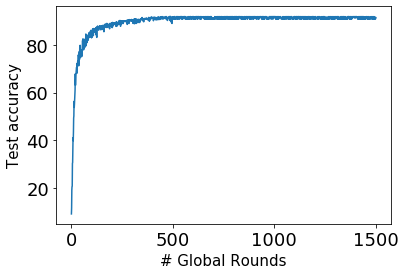

In [23]:
import matplotlib
step=1500
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
#plt.plot(range(len(Cluster0_minor1)), Cluster0_minor1,label="users=2,5,5,6,7")
plt.plot(range(len(acc_test_arr[0:step])), acc_test_arr[0:step],label="without sparsification")
plt.ylabel('Test accuracy')
plt.xlabel('# Global Rounds')
#plt.legend()
#plt.figure(figsize=(6,5), dpi=400)
plt.show()

In [25]:
print(loss_train)

[1.6491554711276184, 1.5024064550052092, 1.3924869397130837, 1.3312144062702573, 1.222071017248004, 1.1731575765736673, 1.1145502479319216, 1.0574275078431326, 1.0199915971579379, 1.0140965826074695, 0.9659317571904372, 0.9388172375069307, 0.9298470876838458, 0.9168535306035644, 0.874817653379093, 0.848639700817013, 0.8236407372448594, 0.8146608100490023, 0.7955936311554437, 0.7791549853783931, 0.7672663901001215, 0.7600518471303536, 0.736788934488712, 0.7352621616331724, 0.7208112125809268, 0.717346842389088, 0.700390204069791, 0.7009602813220033, 0.6950930084984885, 0.6694563664399149, 0.6822536911222118, 0.6499719356527308, 0.6399804110406396, 0.644207992210415, 0.6457810158315288, 0.618699245427442, 0.6401576056862595, 0.6333654608071728, 0.6256551838153973, 0.633593474908611, 0.6059496763360653, 0.6099069040088432, 0.6015849576223666, 0.5962504351249447, 0.6131908170581813, 0.5897548301251503, 0.5982357975423412, 0.5993552733316191, 0.5703838121838417, 0.5866522043769644, 0.581961

In [24]:
print(acc_test_arr)

[9.260000228881836, 11.760000228881836, 19.270000457763672, 20.670000076293945, 20.84000015258789, 30.360000610351562, 30.780000686645508, 36.189998626708984, 41.13999938964844, 39.900001525878906, 43.599998474121094, 49.34000015258789, 50.189998626708984, 56.310001373291016, 53.79999923706055, 55.2400016784668, 57.4900016784668, 60.529998779296875, 61.09000015258789, 67.80000305175781, 63.06999969482422, 65.51000213623047, 67.29000091552734, 68.19000244140625, 69.0, 70.45999908447266, 70.27999877929688, 72.12000274658203, 68.1500015258789, 71.73999786376953, 72.33000183105469, 73.05999755859375, 71.69999694824219, 73.3499984741211, 75.76000213623047, 74.87000274658203, 71.18000030517578, 73.41000366210938, 74.4800033569336, 77.16999816894531, 73.91999816894531, 78.70999908447266, 79.16000366210938, 79.76000213623047, 76.3499984741211, 74.72000122070312, 76.3499984741211, 77.81999969482422, 77.2699966430664, 77.7300033569336, 76.12000274658203, 75.0999984741211, 76.19000244140625, 78.0

In [ ]:
#torch.save(net_glob.state_dict(),"model_cnn.pt")
#for k in w_glob.keys():
#print(w_glob['conv1.weight'].to(torch.device("cuda"))-w_glob['conv1.weight'].to(torch.device("cuda")))

In [ ]:
print((w_glob))